# Семинар №9
## Метод решающих деревьев

### Собственная реализация решающего дерева

Датасет на два класса (два варианта)

In [34]:
# dataset = [[2.771244718,1.784783929,0],
# 	[1.728571309,1.169761413,0],
# 	[3.678319846,2.81281357,0],
# 	[3.961043357,2.61995032,0],
# 	[2.999208922,2.209014212,0],
# 	[7.497545867,3.162953546,1],
# 	[9.00220326,3.339047188,1],
# 	[7.444542326,0.476683375,1],
# 	[10.12493903,3.234550982,1],
# 	[6.642287351,3.319983761,1]]
dataset = [[2.771244718,1.784783929,1],
	[1.728571309,1.169761413,1],
	[3.678319846,2.81281357,0],
	[3.961043357,2.61995032,0],
	[2.999208922,2.209014212,0],
	[7.497545867,3.162953546,1],
	[9.00220326,3.339047188,0],
	[7.444542326,0.476683375,1],
	[10.12493903,3.234550982,1],
	[6.642287351,3.319983761,0]]

Критерий Джинни
\begin{align}
        H(R) = \sum_{k=1}^K p_k(1-p_k), \\
        H(R) = 1-\sum_{k=1}^K p_k^2
\end{align}

In [23]:
# Разрезаем массив на два массива основываясь на номере атрибута и его значении 
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Рассчитываем индекс Джинни для разрезанного датасета
# Если индекс равен 0, значит, все примеры результирующего множества относятся к одному классу. 
# Если равен 1, значит, классы представлены в равных пропорциях и равновероятны.
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# выбираем наилучшую точку разделение датасета
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# создаем лист дерева (терминальный узел)
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Делим node на части рекурсивно
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# Нет разделения - дошли до полного деления
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# Проверяем на максимальную высоту дерева
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# рекурсивно обрабатываем левое поддерево
    # проверяем на минимальное количество в листе
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# рекурсивно обрабатываем правое поддерево
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)

# Строим дерево
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root

# Печатаем дерево
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

Строим дерево

In [37]:
tree = build_tree(dataset, 2, 1)
print_tree(tree)

[X2 < 2.209]
 [X1 < 2.771]
  [1]
  [1]
 [X1 < 7.498]
  [0]
  [1]


Сделать предсказание записи по созданному дереву

In [28]:
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

Предсказываем по пню, актуально для первого варианта датасета

In [30]:
stump = {'index': 0, 'right': 1, 'value': 6.642287351, 'left': 0}
for row in dataset:
	prediction = predict(stump, row)
	print('Expected=%d, Got=%d' % (row[-1], prediction))

Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1


Предсказываем по обученному дереву, актуально для второго варианта датасета

In [38]:
for row in dataset:
	prediction = predict(tree, row)
	print('Expected=%d, Got=%d' % (row[-1], prediction))

Expected=1, Got=1
Expected=1, Got=1
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=0, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=0, Got=0


### Пример на реальном датасете

In [39]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import random 
import numpy as np

random.seed(0)
np.random.seed(0)

набор данных о диабете индейцев Pima

In [8]:
! wget https://github.com/plotly/datasets/raw/master/diabetes.csv

--2023-03-25 15:55:29--  https://github.com/plotly/datasets/raw/master/diabetes.csv
Распознаётся github.com (github.com)… 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv [переход]
--2023-03-25 15:55:30--  https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 23873 (23K) [text/plain]
Сохранение в: «diabetes.csv.4»

diabetes.csv.4      100%[===================>]  23,31K  --.-KB/s    за 0,01s   

2023-03-25 15:55:30 (2,31 MB/s) - «diabetes.csv.4» сохранён [23873/23873]



In [40]:
pima = pd.read_csv("diabetes.csv")

In [41]:
pima
# pima.columns
# Pregnancies - беременность
# Glucose - сахар d rhjdb
# BloodPressure - артериальное давление
# Insulin - инсулин
# BMI -  индекс массы тела(Body Mass Index)
# DiabetesPedigreeFunction - наследственность
# Age - возраст
# Outcome - результат 0/1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [42]:
#split dataset in features and target variable
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
X = pima[feature_cols] # Features
y = pima.Outcome # Target variable

In [43]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [62]:
# Create Decision Tree classifer object
# clf = DecisionTreeClassifier() # разделяем до упора
# clf = DecisionTreeClassifier(max_depth=5) # max_depth ограничение глубины дерева
clf = DecisionTreeClassifier(min_impurity_decrease=0.01) # min_impurity_decrease Узел будет разделен, если это разделение приведет к уменьшению критериря информативности хотя бы на указанное знаачение
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [63]:
y_pred = clf.predict(X_train)

In [65]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train, y_pred))

Accuracy: 0.7821229050279329


In [66]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [67]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7705627705627706


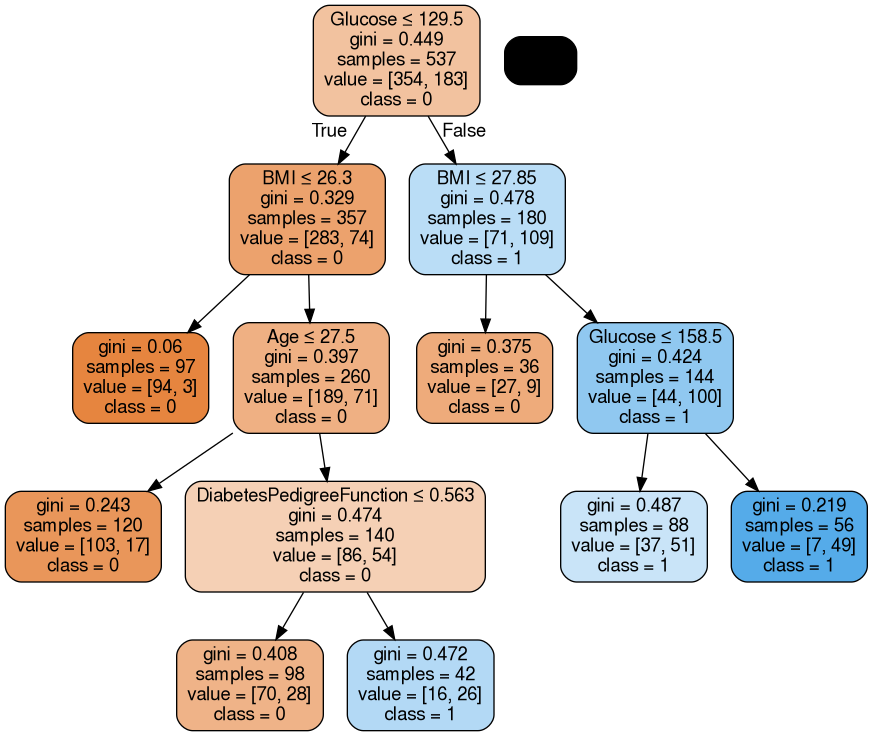

In [68]:
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from six import StringIO
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

[[119  27]
 [ 26  59]]


<AxesSubplot: >

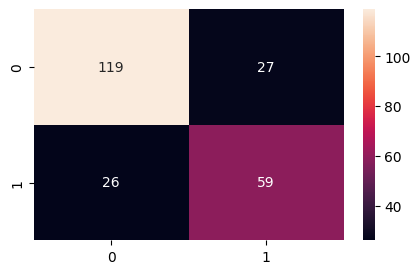

In [69]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
df_cm = pd.DataFrame(confusion_matrix, index = [0,1], columns = [0,1])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True,fmt='g')

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       146
           1       0.69      0.69      0.69        85

    accuracy                           0.77       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



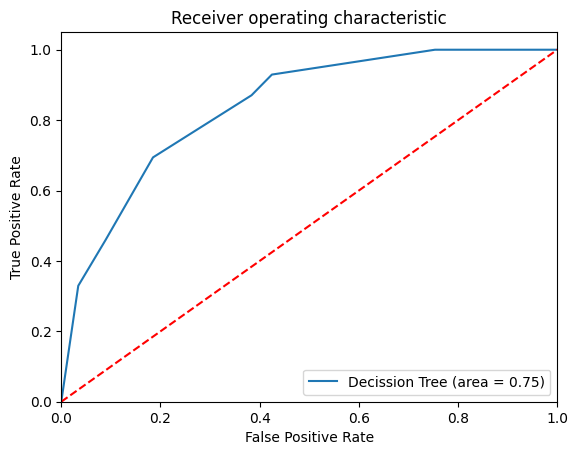

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# fpr, tpr, thresholds = roc_curve(y_test, logreg.predict(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decission Tree (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Сравним с логрег

In [81]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
# logreg = SVC(kernel='linear',probability=True)
logreg.fit(X_train, y_train)

LogisticRegression()

In [82]:
y_pred=logreg.predict(X_test)

In [83]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7835497835497836


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       146
           1       0.78      0.58      0.66        85

    accuracy                           0.78       231
   macro avg       0.78      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231

